# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

Link: <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data">Kaggle challenge</a>

### Libraries

In [1]:
%pylab inline
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pylab import savefig
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Helpers

In [2]:
def get_name_zone(value):
    if value == "A":
        return "Agriculture"
    elif value == "C":
        return "Commercial"
    elif value == "FV":
        return "Floating Village Residential"
    elif value == "I":
        return "Industrial"
    elif value == "RH":
        return "Residential High Density"
    elif value == "RL":
        return "Residential Low Density"
    elif value == "RP":
        return "Residential Low Density Park"
    elif value == "RM":
        return "Residential Medium Density"
    
def get_name_shape(value):
    if value == "Reg":
        return "Regular"
    elif value == "IR1":
        return "Slightly irregular"
    elif value == "IR2":
        return "Moderately Irregular"
    elif value == "IR3":
        return "Irregular"
    
# Getting informations about mean and standard deviation
def info_stats(value):
    return ds.groupby(value)['SalePrice'].agg(["mean", "std"])

def barplot_horizontal(column, title):
    ds[column]\
        .value_counts()\
        .sort_values(ascending=True)\
        .plot(kind='barh', figsize=[14, 7], width=0.6, alpha=0.6, color='r',grid=False,title=title)

# Showing infos in a plot boxplot
def boxplot(val1, val2, xlabel, ylabel, title, rot):
    ax = ds[[val1, val2]].boxplot(by=val2, figsize=(10, 6), rot=rot)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title);
    plt.suptitle('') 

### Global variables

In this section, the variables that will be queried during the analysis will be initialized.

In [3]:
test = "dataset/test.csv"
train = "dataset/train.csv"

### Importing datasets (train and test) to dataframe of pandas

In [4]:
ds = pandas.read_csv(train, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Getting informations about data

In [5]:
ds.shape

(1460, 81)

In [6]:
ds.describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460,1460,1460,1201,1460,1460,91,1460,1460,1460,...,1460,7,281,54,1460,1460,1460,1460,1460,1460
unique,1460,15,5,110,1073,2,2,4,4,2,...,8,3,4,4,21,12,5,9,6,663
top,874,20,RL,60,7200,Pave,Grvl,Reg,Lvl,AllPub,...,0,Gd,MnPrv,Shed,0,6,2009,WD,Normal,140000
freq,1,536,1151,143,25,1454,50,925,1311,1459,...,1453,3,157,49,1408,253,338,1267,1198,20


### Checking the amount of null data in the file

In [7]:
for col in list(ds.columns.values):
    if ds[col].isnull().values.sum() > 0:
        print ("Number of missing data on " + col + ":" ,ds[col].isnull().values.sum())

Number of missing data on LotFrontage: 259
Number of missing data on Alley: 1369
Number of missing data on MasVnrType: 8
Number of missing data on MasVnrArea: 8
Number of missing data on BsmtQual: 37
Number of missing data on BsmtCond: 37
Number of missing data on BsmtExposure: 38
Number of missing data on BsmtFinType1: 37
Number of missing data on BsmtFinType2: 38
Number of missing data on Electrical: 1
Number of missing data on FireplaceQu: 690
Number of missing data on GarageType: 81
Number of missing data on GarageYrBlt: 81
Number of missing data on GarageFinish: 81
Number of missing data on GarageQual: 81
Number of missing data on GarageCond: 81
Number of missing data on PoolQC: 1453
Number of missing data on Fence: 1179
Number of missing data on MiscFeature: 1406


### Verifying the relation of <i>zones</i> with the average price

In [8]:
# Converting data type
ds['SalePrice'] = ds['SalePrice'].apply(pandas.to_numeric)
ds['MSZoningDesc'] = ds['MSZoning'].apply(get_name_zone)

In [9]:
# Showing results
info_stats('MSZoningDesc')

,mean,std
MSZoningDesc,,
Floating Village Residential,214014.061538,52369.662067
Residential High Density,131558.375000,35714.118435
Residential Low Density,191004.994787,80766.341319
Residential Medium Density,126316.830275,48521.689833


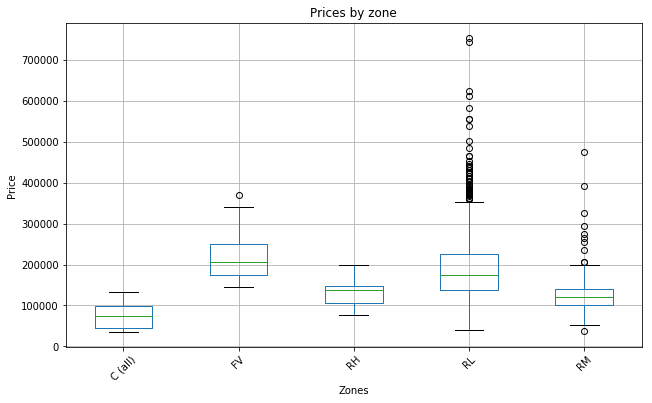

In [10]:
boxplot('SalePrice', 'MSZoning', 'Zones', 'Price', 'Prices by zone', 45)

In above plot, it is possible see many outliers data to Residential Low Density and it has more variability than other groups.

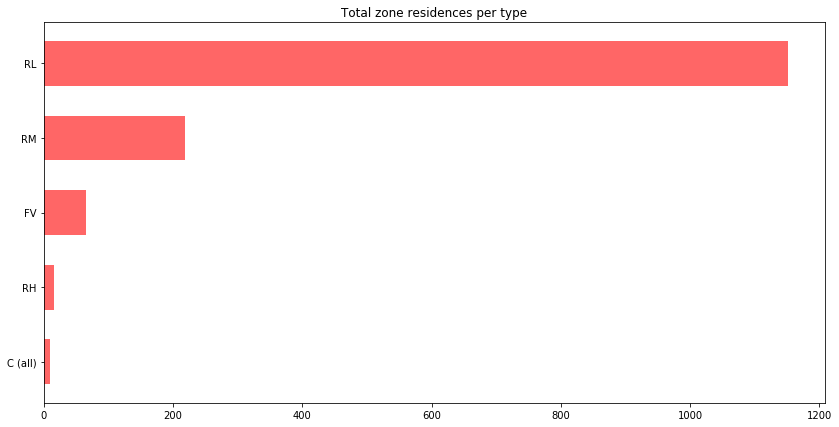

In [11]:
barplot_horizontal('MSZoning', 'Total zone residences per type')

Analyzing the above images, it is possible to conclude that in the data obtained, there are more residences of the type "Residential Low Density", with a greater variability among their values, indicating that it is necessary to use more properties to predict their prices. Some types do not have as much variance and less quantity as "Commercial" and "Residential High Density"

### Verifying the relation between <i>shape of property</i> with the average price

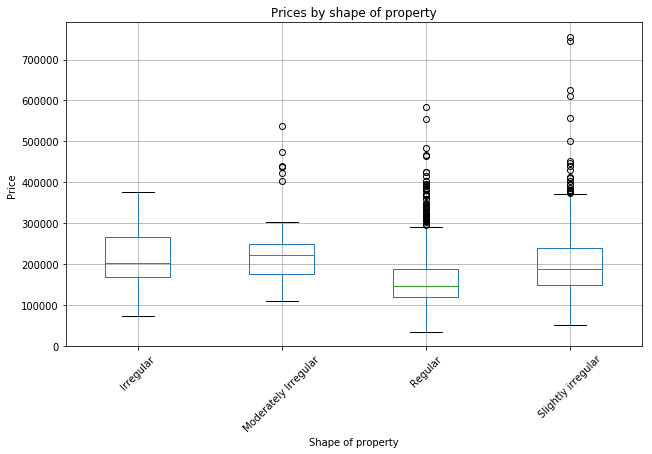

In [12]:
ds['LotShapeDesc'] = ds['LotShape'].apply(get_name_shape)
boxplot('SalePrice', 'LotShapeDesc', 'Shape of property', 'Price', 'Prices by shape of property', 45)

In [13]:
info_stats('LotShapeDesc')

,mean,std
LotShapeDesc,,
Irregular,216036.500000,82540.334855
Moderately Irregular,239833.365854,99669.427362
Regular,164754.818378,69673.427215
Slightly irregular,206101.665289,85858.489559


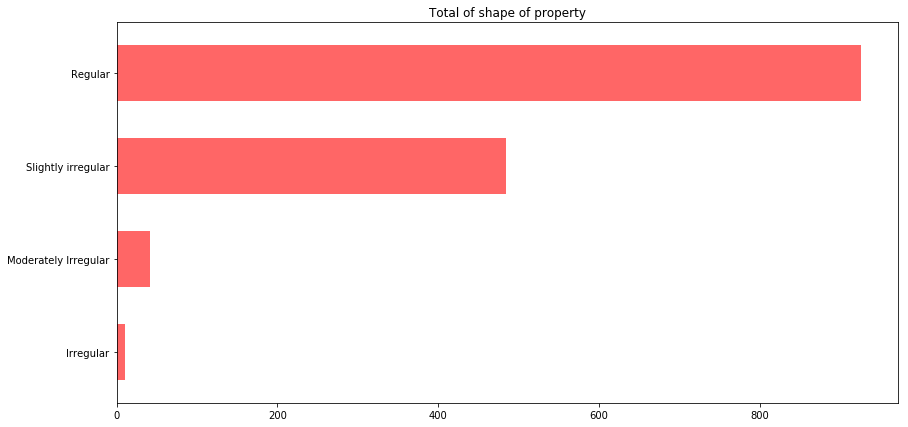

In [14]:
barplot_horizontal('LotShapeDesc', 'Total of shape of property')

In the above plots, it is possible to observe that there are more properties of the regular format, presenting outliers data as well. The price variance of the types of formats are not dissimilar. Properties of type "Moderately Irregular" have a higher average prices and "Regular" properties are the cheapest.

### Pearson Correlation

In this sections, the types data will be changed in numeric for be able to use in Pearson Correlation technique.

In [26]:
ds['OverallCond'] = ds['OverallCond'].apply(pandas.to_numeric)
ds['MSSubClass'] = ds['MSSubClass'].apply(pandas.to_numeric)
ds['OverallQual'] = ds['OverallQual'].apply(pandas.to_numeric)
ds['LotArea'] = ds['LotArea'].apply(pandas.to_numeric)
ds['YearBuilt'] = ds['YearBuilt'].apply(pandas.to_numeric)
#ds['LotFrontage'] = ds['LotFrontage'].apply(pandas.to_numeric)

In [27]:
ds_corr = ds[['OverallCond', 'OverallQual', 'MSSubClass', 'MSZoning', 'SalePrice', 'LotArea', 'Neighborhood', 'YearBuilt']]\
    .assign(MSZoning=ds.MSZoning.astype('category').cat.codes)\
    .assign(Neighborhood=ds.Neighborhood.astype('category').cat.codes)
ds_corr.head()

,OverallCond,OverallQual,MSSubClass,MSZoning,SalePrice,LotArea,Neighborhood,YearBuilt
0,5,7,60,3,208500,8450,5,2003
1,8,6,20,3,181500,9600,24,1976
2,5,7,60,3,223500,11250,5,2001
3,5,7,70,3,140000,9550,6,1915
4,5,8,60,3,250000,14260,15,2000


Normalizing the data between 0 and 1.

In [28]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(ds_corr)
df_norm = pandas.DataFrame(x_scaled)
df_norm.columns = ['OverallCond', 'OverallQual', 'MSSubClass', 'MSZoning', 'SalePrice', 'LotArea', 'Neighborhood', 'YearBuilt']
df_norm.head()

,OverallCond,OverallQual,MSSubClass,MSZoning,SalePrice,LotArea,Neighborhood,YearBuilt
0,0.500,0.666667,0.235294,0.75,0.241078,0.033420,0.208333,0.949275
1,0.875,0.555556,0.000000,0.75,0.203583,0.038795,1.000000,0.753623
2,0.500,0.666667,0.235294,0.75,0.261908,0.046507,0.208333,0.934783
3,0.500,0.666667,0.294118,0.75,0.145952,0.038561,0.250000,0.311594
4,0.500,0.777778,0.235294,0.75,0.298709,0.060576,0.625000,0.927536


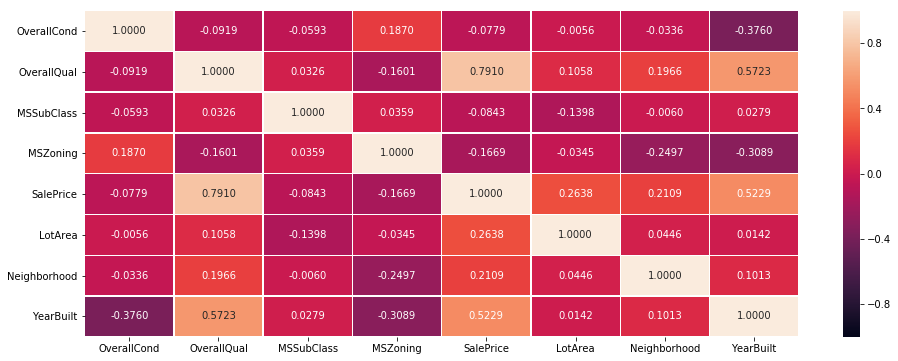

In [31]:
plt.figure(figsize = (16,6))
sns.heatmap(df_norm.corr(), annot=True, fmt=".4f", vmin=-1, vmax=1, linewidths=.5)
plt.show()